<a href="https://colab.research.google.com/github/Puurun/fastai_code_example/blob/main/Pytorch_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /'content/drive/MyDrive/Colab Notebooks'/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip

Mounted at /content/drive
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 28.9MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install impyute

In [ ]:
!pip install fastai -Uqq

     |████████████████████████████████| 188 kB 7.5 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 


In [677]:
gpu = False
device = 'cuda' if gpu else 'cpu'

In [889]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import impyute as im
import sys
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import OrdinalEncoder

In [890]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [891]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [892]:
dep_var = ['Survived']
cat_var = ['Sex', 'Embarked']
ord_var = ['Pclass']
cont_var = ['Age', 'Fare']
desc_var = ['SibSp', 'Parch']

In [893]:
combine = [df, df_test]
for dataset in combine:
    dataset[cat_var+ord_var] = dataset[cat_var+ord_var].astype('category')
    dataset['Pclass'] = dataset['Pclass'].cat.set_categories([1, 2, 3], ordered=True)

In [894]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [895]:
null_check = (df.isnull().sum()/ df.isnull().count()).sort_values(ascending=False)
null_check

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [896]:
df.info()
print('*'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       ----------

In [897]:
df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [898]:
df.describe(include=['O'])

,Name,Ticket,Cabin
count,891,891,204
unique,891,681,147
top,"Braund, Mr. Owen Harris",347082,B96 B98
freq,1,7,4


In [899]:
# analyze by pivoting features
features_to_analyze = ['Pclass', 'SibSp', 'Parch', 'Sex']
pivot_analyzation = {
    feature: 
    df[[feature, 'Survived']].groupby(by=[feature], as_index=False).mean().sort_values(by="Survived", ascending=False)
    for feature in features_to_analyze
}

In [900]:
pivot_analyzation['Pclass']

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [901]:
pivot_analyzation['Sex']

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [902]:
pivot_analyzation['SibSp']

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [903]:
pivot_analyzation['Parch']

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


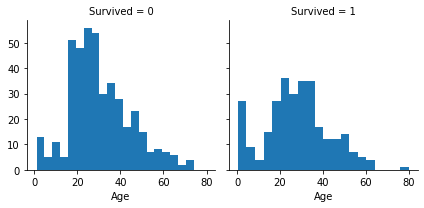

In [904]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

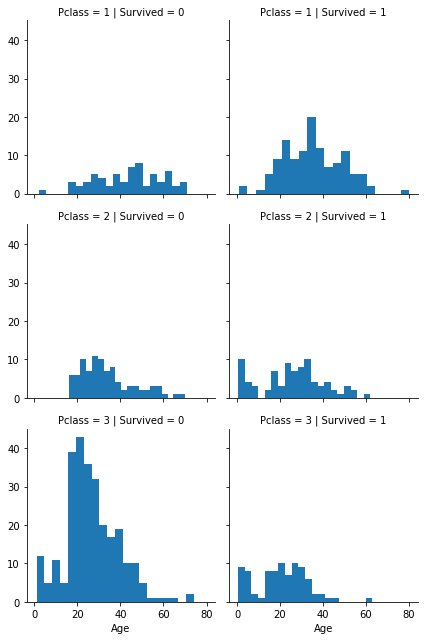

In [905]:
g = sns.FacetGrid(df, col='Survived', row='Pclass')
g.map(plt.hist, 'Age', bins=20)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


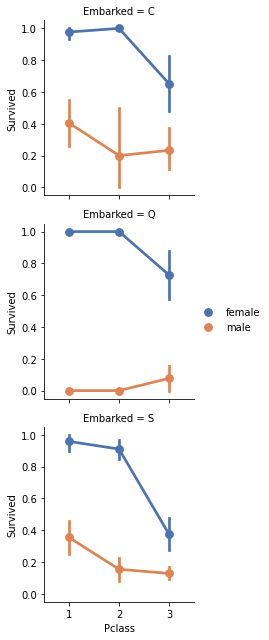

In [906]:
g = sns.FacetGrid(df, row='Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


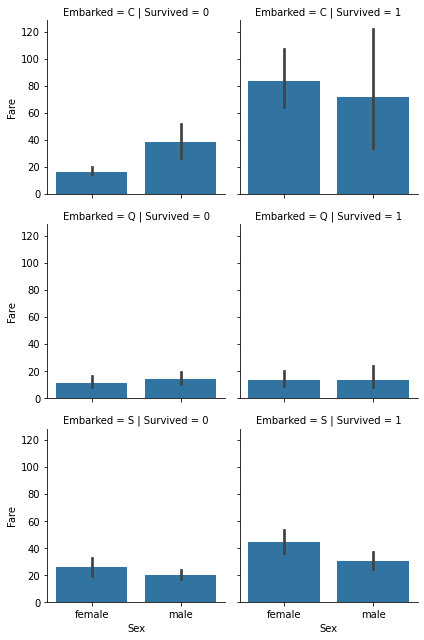

In [907]:
g= sns.FacetGrid(df, row='Embarked', col='Survived')
g.map(sns.barplot, 'Sex', 'Fare')

In [908]:
df = df.drop(['Cabin', 'Ticket'], axis=1)

In [909]:
df_test = df_test.drop(['Cabin', 'Ticket'], axis=1)

In [910]:
df_test_pi = df_test.copy()['PassengerId']

In [911]:
combine = [df, df_test]
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [912]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
df[['Survived', 'Title']].groupby('Title', as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [913]:
df.notnull().mean()

PassengerId    1.000000
Survived       1.000000
Pclass         1.000000
Name           1.000000
Sex            1.000000
Age            0.801347
SibSp          1.000000
Parch          1.000000
Fare           1.000000
Embarked       0.997755
Title          1.000000
dtype: float64

In [914]:
for dataset in combine:
    dataset.drop(['Name', 'PassengerId'], axis=1, inplace=True)

In [915]:
def categorify(df, df_test):
    df = df.copy()
    df_test = df_test.copy()
    new = pd.concat([df, df_test])
    sexdict = {k[1]: k[0] for k in enumerate(new['Sex'].unique())}
    embdict = {k[1]: k[0] for k in enumerate(new['Embarked'].unique())}
    titdict = {k[1]: k[0] for k in enumerate(new['Title'].unique())}
    pardict = {k[1]: k[0] for k in enumerate(new['Parch'].unique())}
    pcldict = {k[1]: k[0] for k in enumerate(new['Pclass'].astype(int).unique())}
    sibdict = {k[1]: k[0] for k in enumerate(new['SibSp'].astype(int).unique())}
    dicts = {'Sex': sexdict, 'Embarked': embdict, 'Title': titdict, 'Parch': pardict, 'Pclass': pcldict, 'SibSp':sibdict}
    for key, val in dicts.items():
        df[key] = df[key].map(val).astype(float)
        df_test[key] = df_test[key].map(val).astype(float)
    return df, df_test

In [916]:
combine = [df, df_test]
df, df_test = categorify(df, df_test)

In [917]:
from sklearn.impute import KNNImputer

In [918]:
imp = KNNImputer()

In [919]:
df = pd.DataFrame(imp.fit_transform(df.values), columns=df.columns)
df_test = pd.DataFrame(imp.fit_transform(df_test.values), columns=df_test.columns)

In [920]:
df['Embarked'] = df['Embarked'].astype(int)
df_test['Embarked'] = df_test['Embarked'].astype(int)

In [921]:
for i in df:
    print(f'key: {i}, unique: {df[i].nunique()}')
print('-'*10)
for i in df_test:
    print(f'key: {i}, unique: {df[i].nunique()}') 

key: Survived, unique: 2
key: Pclass, unique: 3
key: Sex, unique: 2
key: Age, unique: 144
key: SibSp, unique: 7
key: Parch, unique: 7
key: Fare, unique: 248
key: Embarked, unique: 3
key: Title, unique: 5
----------
key: Pclass, unique: 3
key: Sex, unique: 2
key: Age, unique: 144
key: SibSp, unique: 7
key: Parch, unique: 7
key: Fare, unique: 248
key: Embarked, unique: 3
key: Title, unique: 5


In [922]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.0,0.0,34.500,1.0,0.0,7.8292,2,0.0
1,0.0,1.0,47.000,0.0,0.0,7.0000,0,1.0
2,2.0,0.0,62.000,1.0,0.0,9.6875,2,0.0
3,0.0,0.0,27.000,1.0,0.0,8.6625,0,0.0
4,0.0,1.0,22.000,0.0,1.0,12.2875,0,1.0
...,...,...,...,...,...,...,...,...
413,0.0,0.0,32.900,1.0,0.0,8.0500,0,0.0
414,1.0,1.0,39.000,1.0,0.0,108.9000,1,5.0
415,0.0,0.0,38.500,1.0,0.0,7.2500,0,0.0
416,0.0,0.0,32.900,1.0,0.0,8.0500,0,0.0


In [923]:
from torch.nn import *
from torch import nn

In [924]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

In [925]:
cat = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title']]
cont = df[['Age', 'Fare']]
cat.join(cont).iloc[0]
dv = df['Survived']
dv.iloc[0]
df.index[3]

3

In [926]:
def randomSplit(df, valid_ratio=0.2, random_state=None):
    split_idx = int(len(df.index)*(valid_ratio))
    shuffled_df = df.sample(frac=1, random_state=random_state)
    return shuffled_df.iloc[split_idx:], shuffled_df[:split_idx]

In [927]:
class TitanicDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.is_test = is_test
        self.df = df.copy()
        self.cat = self.df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title']].astype(int)
        self.cont = self.df[['Age', 'Fare']]
        self.res_df = self.cat.join(self.cont)
        if not(is_test):
            self.dep_var = self.df['Survived'].astype(int)
        self.columns = self.res_df.columns
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        if self.is_test:
            return self.res_df.iloc[idx].values
        else:
            return self.res_df.iloc[idx].values, self.dep_var.iloc[idx]

In [928]:
train_df, valid_df = randomSplit(df)

In [929]:
td = TitanicDataset(train_df)
valid_td = TitanicDataset(valid_df)
test_ds = TitanicDataset(df_test, is_test=True)
in_columns = td.columns
cat_columns = td.cat.columns
cat_n = len(td.cat.columns)
cont_n = len(td.cont.columns)

In [930]:
dl = DataLoader(td, batch_size=64)
valid_dl = DataLoader(td, batch_size=64)

In [931]:
iterdl = iter(dl)

In [932]:
voc = []
for s in cat_columns:
    vn = pd.concat([td.cat[s], valid_td.cat[s], test_ds.cat[s]])
    vn = vn.astype(int).nunique()
    voc.append([vn, vn//2+1])


In [933]:
voc

[[3, 2], [2, 2], [7, 4], [8, 5], [3, 2], [6, 4]]

In [946]:
class TabModel(Module):
    def __init__(self, emb_sz, cat_n, cont_n, layers):
        super(TabModel, self).__init__()
        self.cat_n = cat_n
        self.cont_n = cont_n
        self.embeddings = nn.ModuleList(nn.Embedding(ni, nf) for ni, nf in emb_sz)
        cat_len = sum([x for _, x in emb_sz])
        self.emb_drop = nn.Dropout(0.2)
        self.linear_drop = nn.Dropout(0.5)
        model = []
        model.append(nn.BatchNorm1d(cat_len+cont_n))
        model.append(self.linear_drop)
        model.append(nn.Linear(cat_len+cont_n, layers[0]))
        model.append(nn.Mish())
        for i in range(len(layers)-2):
            model.append(nn.BatchNorm1d(layers[i]))
            model.append(self.linear_drop)
            model.append(nn.Linear(layers[i], layers[i+1]))
            model.append(nn.Mish())
        self.linear = nn.Sequential(*model)
        self.final_layer = nn.Linear(layers[-2], layers[-1])
        
    def forward(self, x):
        emb = []
        for i in range(self.cat_n):
            emb.append(self.embeddings[i](x[:,i].int()))
        for i in range(self.cat_n, self.cat_n+self.cont_n):
            emb.append(x[:,i].unsqueeze(1))
        input = torch.cat(emb, dim=1).float()
        res = self.linear(input)
        res = self.final_layer(res)
        return res


In [947]:
tabmodel = TabModel(voc, cat_n, cont_n, (200, 100, 2)).to(device)

In [948]:
print(tabmodel)

TabModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 2)
    (2): Embedding(7, 4)
    (3): Embedding(8, 5)
    (4): Embedding(3, 2)
    (5): Embedding(6, 4)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (linear_drop): Dropout(p=0.5, inplace=False)
  (linear): Sequential(
    (0): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=21, out_features=200, bias=True)
    (3): Mish()
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): Mish()
  )
  (final_layer): Linear(in_features=100, out_features=2, bias=True)
)


In [949]:
dls = dl, valid_dl

In [950]:
def train(dl, model, loss_fn, optim):
    size = len(dl.dataset)
    losses = []
    for batch, (X, y) in enumerate(dl):
        # prediction, loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
    
    print(f'loss: {np.array(losses).mean()}')


In [951]:
def valid(valid_dl, model, loss_fn):
    accuracy = []
    losses = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(valid_dl):
            #p rediction, loss
            pred = model(X)
            loss = loss_fn(pred, y)
            # metric
            accuracy.append((pred.argmax(1)==y).float().flatten().mean())
            losses.append(loss.item())
    print(f'valid -- accuracy: {np.array(accuracy).mean()}, loss: {np.array(losses).mean()}')

In [952]:
def epoch(n, dls, model:Module, loss_fn):
    train_dl, valid_dl = dls
    
    for i in range(n):
        # train
        model.train()
        train(train_dl, model, loss_fn, torch.optim.Adam(model.parameters(), lr= 1e-3))
        #validate
        model.eval()
        valid(valid_dl, model, loss_fn)

In [953]:
epoch(10, dls, tabmodel, CrossEntropyLoss())

loss: 0.5841824933886528
valid -- accuracy: 0.7993345260620117, loss: 0.4934114913145701
loss: 0.5340044101079305
valid -- accuracy: 0.8019387125968933, loss: 0.46828504155079526
loss: 0.48861031730969745
valid -- accuracy: 0.8032407760620117, loss: 0.45460598667462665
loss: 0.5007103582223257
valid -- accuracy: 0.8162615895271301, loss: 0.442501666645209
loss: 0.515445334215959
valid -- accuracy: 0.8227720260620117, loss: 0.4506382718682289
loss: 0.5071123068531355
valid -- accuracy: 0.8227720260620117, loss: 0.4386831323305766
loss: 0.5216201494137446
valid -- accuracy: 0.8227720260620117, loss: 0.442587507267793
loss: 0.4934941679239273
valid -- accuracy: 0.8136574625968933, loss: 0.4424523363510768
loss: 0.49193543940782547
valid -- accuracy: 0.8188657760620117, loss: 0.43694161375363666
loss: 0.5041593884428343
valid -- accuracy: 0.8227720260620117, loss: 0.4376588960488637


In [954]:
def predictWhole(data, model):
    model.eval()
    pred = model(data)
    return pred.argmax(1)

In [955]:
test_ds_raw = torch.Tensor(np.array(test_ds))

In [956]:
test_ds_raw

tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000, 34.5000,  7.8292],
        [ 0.0000,  1.0000,  0.0000,  ...,  1.0000, 47.0000,  7.0000],
        [ 2.0000,  0.0000,  1.0000,  ...,  0.0000, 62.0000,  9.6875],
        ...,
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000, 38.5000,  7.2500],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000, 32.9000,  8.0500],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.0000,  9.4340, 22.3583]])

In [957]:
preds = predictWhole(test_ds_raw, tabmodel)
len(preds)

418

In [963]:
result = pd.DataFrame({'PassengerId': df_test_pi, 'Survived': preds})

In [965]:
result.to_csv('submission.csv', index=False)